In [ ]:
import pandas as pd
import numpy as np


In [ ]:
import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Datapoints[1].xlsx - Sheet1.csv")
df.head(45)

,Axial Depth(mm),Spindle Speed(RPM),Stability condition (1=stable)
0,4,10000,0
1,4,10500,0
2,4,11000,1
3,4,11500,1
4,4,12000,1
5,4,12500,0
6,4,13000,0
7,4,13500,0
8,4,14000,1
9,4,14500,1


In [ ]:
ad_min=0
ad_max=20
ad_stepsize=0.01
ss_min=10000
ss_max=20000
ss_stepsize=5
ad=np.linspace(ad_min,ad_max,2001)
ss=np.linspace(ss_min,ss_max,2001)


In [ ]:
ele_ad=np.size(ad)
ele_ss=np.size(ss)
pd=np.zeros([ele_ad,ele_ss])
bt=df.iloc[:,0]
Nt=df.iloc[:,1]
stability=df.iloc[:,2]
testsize=len(bt)
sig=(3/100)*(ss_max-ss_min)  
sig_b=(10/100)*(ad_max-ad_min)
print(stability)


0     0
1     0
2     1
3     1
4     1
5     0
6     0
7     0
8     1
9     1
10    1
11    1
12    1
13    1
14    0
15    0
16    0
17    0
18    0
19    1
20    1
21    0
22    1
23    1
24    0
25    1
26    1
27    1
28    1
29    0
30    0
31    0
32    1
33    0
34    0
35    1
36    1
37    0
38    0
39    1
40    1
41    0
42    1
Name: Stability condition (1=stable), dtype: int64


In [ ]:
def prior(x,ad_min,ad_max):
  y=((0.05-1)/(ad_max-ad_min))*(x)+(1-((0.05-1)/(ad_max-ad_min))*(ad_min))
  return y

import math
def likeli_stable(i,j,bt,Nt,sig,sig_b):
  bi=i
  Ni=j
  if bi<=bt:
    st=0.5+(math.exp(-0.5*(((Ni-Nt)/sig)**2)))/2
    us=1-st
  else:
    if bi<=bt+3*sig_b:
      deno=math.exp(-0.5*( (bi-(bt+3*sig_b))/(sig_b) )**2)-0.5
      sig_nbi=-sig*bi/(3*sig_b)+sig*(bt+3*sig_b)/(3*sig_b)
    else:
      deno=1-0.5
      sig_nbi=0
    
    
    if(Ni==Nt):

      st=1
      if(bi<=bt+3*sig_b):

        us=math.exp(-0.5*( (bi-(bt+3*sig_b))/(sig_b) )**2)
      else:
        us=1
        
    else:
      if sig_nbi==0:
        us=0.5
        st=0.5
      else:


        st=0.5+(math.exp(-0.5*(((Ni-Nt)/sig_nbi)**2)))/2
        us=0.5+(math.exp(-0.5*(((Ni-Nt)/sig_nbi)**2)))/(1/(deno))
  return st,us    


def likeli_unstable(i,j,bt,Nt,sig,sig_b):
  bi=i
  Ni=j
  if bi>=bt:
    us=0.5+(math.exp(-0.5*(((Ni-Nt)/sig)**2)))/2
    st=1-us
  else:
    if bi<=bt+3*sig_b:
       deno=math.exp(-0.5*( (bi-(bt-3*sig_b))/(sig_b) )**2)-0.5
       sig_nbi=sig*bi/(3*sig_b)-sig*(bt-3*sig_b)/(3*sig_b)
    else:
      deno=0.5
      sig_nbi=0
    if(Ni==Nt):

      us=1 
      if(bi>=bt-3*sig_b):
        st=math.exp(-0.5*( (bi-(bt-3*sig_b))/(sig_b) )**2)
      else:
        st=1
    else:
      if sig_nbi==0:
        us=0.5
        st=0.5
      else:
        us=0.5+(math.exp(-0.5*(((Ni-Nt)/sig_nbi)**2)))/2
        st=0.5+(math.exp(-0.5*(((Ni-Nt)/sig_nbi)**2)))/(1/(deno))
  return st,us


def generate_lobes(bt,Nt,sig,sig_b,stability,pd,ad_min,ad_max,ss_min,ss_max,ad_stepsize,ss_stepsize):
  priorM=pd
  SposteriorM=pd
  UposteriorM=pd
  l=0
  i=ad_min
  while i<=ad_max and i>=ad_min:
      
    k=0
    j=ss_min
    while j<=ss_max and j>=ss_min:
         
      if(stability==1):
          st,us=likeli_stable(i,j,bt,Nt,sig,sig_b)
          SposteriorM[l,k]=priorM[l,k]*st/(priorM[l,k]*st+us*(1-priorM[l,k]))
      else:
          st,us=likeli_unstable(i,j,bt,Nt,sig,sig_b)
          UposteriorM[l,k]=priorM[l,k]*st/(priorM[l,k]*st+us*(1-priorM[l,k]))
      j=j+ss_stepsize
      k=k+1
    l=l+1
    i=i+ad_stepsize      

  if(stability==1):
      final_lobe=SposteriorM
  else:
      final_lobe=UposteriorM
  
  return final_lobe










  


In [ ]:
for i in range(ele_ad):
  pd[i,:]=prior(i,ad_min,(ad_max-ad_min)/ad_stepsize+1)
print(pd)










[[1.         1.         1.         ... 1.         1.         1.        ]
 [0.99952524 0.99952524 0.99952524 ... 0.99952524 0.99952524 0.99952524]
 [0.99905047 0.99905047 0.99905047 ... 0.99905047 0.99905047 0.99905047]
 ...
 [0.05142429 0.05142429 0.05142429 ... 0.05142429 0.05142429 0.05142429]
 [0.05094953 0.05094953 0.05094953 ... 0.05094953 0.05094953 0.05094953]
 [0.05047476 0.05047476 0.05047476 ... 0.05047476 0.05047476 0.05047476]]


In [ ]:
for i in range(testsize):
  final_lobe=generate_lobes(bt[i],Nt[i],sig,sig_b,stability[i],pd,ad_min,ad_max,ss_min,ss_max,ad_stepsize,ss_stepsize)
  pd=final_lobe
print(final_lobe)

[[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [9.99202268e-01 9.99202409e-01 9.99203201e-01 ... 9.99999874e-01
  9.99999968e-01 1.00000000e+00]
 [9.98397326e-01 9.98397618e-01 9.98399220e-01 ... 9.99999749e-01
  9.99999936e-01 1.00000000e+00]
 ...
 [0.00000000e+00 2.21027931e-06 8.70320488e-06 ... 8.70320488e-06
  2.21027931e-06 0.00000000e+00]
 [0.00000000e+00 2.18877799e-06 8.61854174e-06 ... 8.61854174e-06
  2.18877799e-06 0.00000000e+00]
 [5.04747626e-02 5.04747626e-02 5.04747626e-02 ... 5.04747626e-02
  5.04747626e-02 5.04747626e-02]]


In [ ]:
import pandas as pd
h = pd.DataFrame(final_lobe)
h.to_csv(r'/content/drive/MyDrive/Colab Notebooks/generated lobes.csv',index=False)

NameError: ignored

In [ ]:
import pandas as pd
h=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/generated lobes.csv')
h.head()

,0,1,2,3,4,5,6,7,8,9,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0
1,0.999202,0.999202,0.999203,0.999205,0.999207,0.999209,0.999213,0.999217,0.999221,0.999226,...,0.999998,0.999998,0.999999,0.999999,0.999999,1.000000,1.000000,1.0,1.0,1.0
2,0.998397,0.998398,0.998399,0.998402,0.998406,0.998412,0.998418,0.998426,0.998435,0.998446,...,0.999996,0.999996,0.999997,0.999998,0.999999,0.999999,0.999999,1.0,1.0,1.0
3,0.997585,0.997586,0.997588,0.997592,0.997599,0.997607,0.997617,0.997629,0.997643,0.997658,...,0.999993,0.999995,0.999996,0.999997,0.999998,0.999999,0.999999,1.0,1.0,1.0
4,0.996765,0.996766,0.996769,0.996775,0.996784,0.996795,0.996808,0.996825,0.996843,0.996864,...,0.999991,0.999993,0.999994,0.999996,0.999997,0.999998,0.999999,1.0,1.0,1.0


In [ ]:
arr = h.to_numpy()
arr

array([[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [9.99202268e-01, 9.99202409e-01, 9.99203201e-01, ...,
        9.99999874e-01, 9.99999968e-01, 1.00000000e+00],
       [9.98397326e-01, 9.98397618e-01, 9.98399220e-01, ...,
        9.99999749e-01, 9.99999936e-01, 1.00000000e+00],
       ...,
       [0.00000000e+00, 2.21027931e-06, 8.70320488e-06, ...,
        8.70320488e-06, 2.21027931e-06, 0.00000000e+00],
       [0.00000000e+00, 2.18877799e-06, 8.61854174e-06, ...,
        8.61854174e-06, 2.18877799e-06, 0.00000000e+00],
       [5.04747626e-02, 5.04747626e-02, 5.04747626e-02, ...,
        5.04747626e-02, 5.04747626e-02, 5.04747626e-02]])

In [ ]:
final_lobe


array([[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [9.99202268e-01, 9.99202409e-01, 9.99203201e-01, ...,
        9.99999874e-01, 9.99999968e-01, 1.00000000e+00],
       [9.98397326e-01, 9.98397618e-01, 9.98399220e-01, ...,
        9.99999749e-01, 9.99999936e-01, 1.00000000e+00],
       ...,
       [0.00000000e+00, 2.21027931e-06, 8.70320488e-06, ...,
        8.70320488e-06, 2.21027931e-06, 0.00000000e+00],
       [0.00000000e+00, 2.18877799e-06, 8.61854174e-06, ...,
        8.61854174e-06, 2.18877799e-06, 0.00000000e+00],
       [5.04747626e-02, 5.04747626e-02, 5.04747626e-02, ...,
        5.04747626e-02, 5.04747626e-02, 5.04747626e-02]])

In [ ]:
import numpy as np
def matrixflip(m,d):
    myl = np.array(m)
    if d=='v': 
        return np.flip(myl, axis=0)
    elif d=='h':
        return np.flip(myl, axis=1)



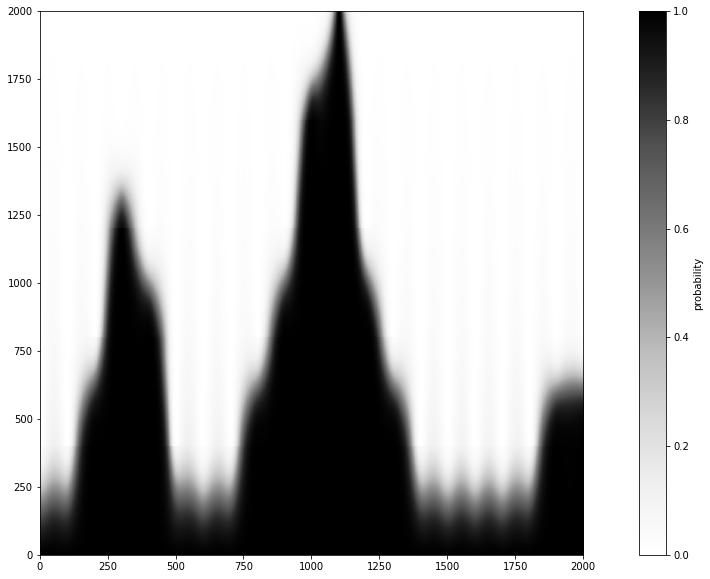

In [ ]:


import matplotlib.pyplot as plt

# data = final_lobe
data1=h
plt.figure(figsize=(20,10))
plt.imshow(h, cmap='Greys', interpolation='none',origin='lower')

plt.colorbar(label="probability", orientation="vertical")





In [ ]:

#to decide stable boundary

stab_boundx=[]
stab_boundy=[]
l=0
for i in np.linspace(ad_min,ad_max,2001):
  k=0
  for j in np.linspace(ss_min,ss_max,2001):
    if (abs(arr[l,k]-0.5))<=0.001:
      stab_boundx.append(j)
      stab_boundy.append(i)
    k=k+1
  l=l+1
 


stablePtx=[]
stablePty=[]
unstablePtx=[]
unstablePty=[]
  

for i in range(testsize):
  
 
  if stability[i]==1:
    stablePtx.append(Nt[i])
    stablePty.append(bt[i])
    
  elif stability[i]==0:
    unstablePtx.append(Nt[i])
    unstablePty.append(bt[i])
    


  










Text(0.5, 0, 'Spindle Speed')

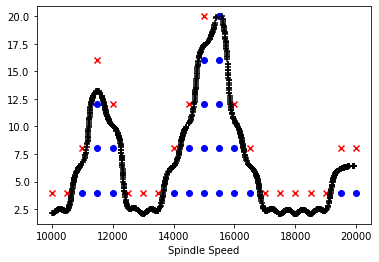

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(stablePtx,stablePty,color='blue',marker='o')
plt.scatter(unstablePtx,unstablePty,color='red',marker='x')
plt.scatter(stab_boundx,stab_boundy,color='black',marker='+')
plt.xlabel("Spindle Speed")
